Sentiment analysis with Keras

Flow

- GloVe (Global Vector) embedding -> custom convolution network, with accuracy as the metric; cross-entropy as loss function, rmsprop as optimizer.

Further tuning

- Use different corpus size glove
- Balance the sample of testing as well.  
(We applied weights accounting the skewed distribution of positive comments in training set, but this has to be done on testing set as well...)
- Apply different metric (not only accuracy, like F1-score, AUC...)

Further work

- collect samples not only from steam, but indie game platforms like itch.io


Codes are modified from

(For GloVe embedding and training)
https://keras.io/examples/nlp/pretrained_word_embeddings/

(For binary classification, and imbalance data)
https://keras.io/examples/structured_data/imbalanced_classification/

(TODO)
For oversampling and undersampling -> build a smoother gradient
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import random

random.seed(13)
# take 15% for both testing and training from original. Then among that 15%, 70% for training, 30% for testing.
p = 0.15

dataset_path = Path('../dataset.csv').resolve()

dataset = pd.read_csv(dataset_path, skiprows=lambda i: i > 0 and random.random() > p)
dataset.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,1
1,10,Counter-Strike,Every server is spanish or french. I can now f...,1,0
2,10,Counter-Strike,Ruined my life. 10/10,1,1
3,10,Counter-Strike,Best shooter for 10 years. Steam evolved becau...,1,0
4,10,Counter-Strike,Old but Gold.,1,1


In [2]:
# first do data cleaning

# convert to string
dataset['review_text'] = dataset['review_text'].astype('str')

In [3]:
dataset = dataset.drop_duplicates(keep='first')

remove some characters, but not do the stop words, stemming and lemmatizing (no doing them in Keras example ??)

In [4]:
import re

def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [5]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [6]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [7]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [8]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [9]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [10]:
def cleaning(df, review_col_name):
    df[review_col_name] = df[review_col_name].apply(clean)
    df[review_col_name] = df[review_col_name].apply(deEmojify)
    df[review_col_name] = df[review_col_name].str.lower()
    df[review_col_name] = df[review_col_name].apply(remove_num)
    df[review_col_name] = df[review_col_name].apply(remove_symbols)
    df[review_col_name] = df[review_col_name].apply(remove_punctuation)

In [11]:
cleaning(dataset, 'review_text')

dataset.head(20)

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,still better than call of duty ghosts,1,1
1,10,Counter-Strike,every server is spanish or french i can now fl...,1,0
2,10,Counter-Strike,ruined my life,1,1
3,10,Counter-Strike,best shooter for years steam evolved because o...,1,0
4,10,Counter-Strike,old but gold,1,1
5,10,Counter-Strike,it s a nice game,1,1
6,10,Counter-Strike,no lag no russian guy saying classic no expen...,1,1
7,10,Counter-Strike,first starting off as a cute little mod based ...,1,1
8,10,Counter-Strike,the game that started it all i love global off...,1,1
9,10,Counter-Strike,if you dont like then you can suck some balls,1,1


In [12]:
from collections import Counter


review_vis2 = dataset.copy()

review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,2382503
1,and,1441320
2,a,1368515
3,to,1319302
4,game,1231436
5,i,1161627
6,it,1138320
7,you,1022911
8,of,1004512
9,is,946505


/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Common_words'>

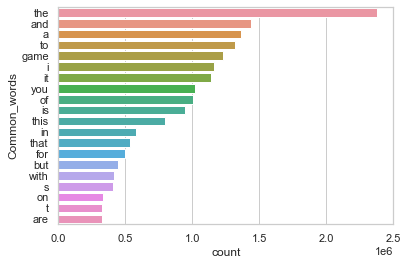

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

Start our ML

In [14]:
X = dataset['review_text']
y = dataset['review_score']

In [15]:
# convert the '-1' in y to '0'
# s.t. 0 represents 'negative'
# 1 represents 'positive'
y = y.replace(-1, 0)


In [16]:
class_names = y.unique()
print(class_names)

[1 0]


In [17]:
# create 
# split to train and test dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.3)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2023-09-17 22:43:52.196595: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-09-17 22:43:52.196845: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-09-17 22:43:52.196855: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-09-17 22:43:52.197908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-17 22:43:52.199350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-17 22:43:52.496072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [19]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'a']

In [20]:
output = vectorizer([["the game looks awesome"]])
output.numpy()[0, :6]

array([  2,   6, 318, 151,   0,   0])

load pre-trained word embeddings

Download glove dataset and place it according to the argument in Path() object

In [21]:
# glove_file_path = Path("glove.6B/glove.6B.100d.txt").resolve()
glove_file_path = Path("../glove.6B/glove.6B.100d.txt").resolve()

embeddings_index = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. 

It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [22]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18283 words (1717 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

In [23]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Build the model

A simple 1D convnet with global max pooling and a classifier at the end.

In [24]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)           # for multi-class probability output
# preds = layers.Dense(1, activation='sigmoid')(x)                             # for single-class output
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

-----

Before training, we need to fix the imbalance nature of the (training) dataset

In [25]:
print('reviews ratio:')
print(y_train.value_counts(normalize=True))

print('\n\n')

print('reviews count')
print(y_train.value_counts())

reviews ratio:
review_score
1    0.82305
0    0.17695
Name: proportion, dtype: float64



reviews count
review_score
1    455619
0     97955
Name: count, dtype: int64


In [26]:
# we create the weights for training
inverse_func = lambda x: 1 / x
class_weight_training = dict(
    (k, inverse_func(v)) for k, v in dict(y_train.value_counts(normalize=True)).items()
)

print(class_weight_training)

class_weight_testing = dict(
    (k, inverse_func(v)) for k, v in dict(y_test.value_counts(normalize=True)).items()
)

print(class_weight_testing)

{1: 1.2149932289917673, 0: 5.651309274666939}
{1: 1.2157109915449653, 0: 5.635832383124288}


Over 80% reviews are positive. We need to balance them s.t. each classes are equally distributed in both training and evaluation data.

Or we pass parameter _class_weight_ to the Keras during training.

Train the model

In [27]:
# we first vectorize the strings (i.e. embedding) for passing to the training pipeline 

X_train_vec = vectorizer(np.array([[s] for s in X_train])).numpy()
X_test_vec = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

get_test_weight = lambda x: class_weight_testing[x]
y_test_weight = np.array([get_test_weight(x) for x in y_test_arr])

In [28]:
print(y_test_arr.shape)
print(y_test_weight.shape)

(237246,)
(237246,)


In [29]:
X_train_vec.shape

(553574, 200)

We use categorical crossentropy as our loss since we're doing softmax classification. 

Moreover, we use sparse_categorical_crossentropy since our labels are integers.

In [38]:
# TODO: add more metrics
# examples
metrics = [
    keras.metrics.SparseCategoricalAccuracy(),
    # keras.metrics.FalseNegatives(name="fn", thresholds=0),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall")
]
model.compile(
    loss="sparse_categorical_crossentropy", optimizer='adam', metrics=metrics, weighted_metrics=keras.metrics.SparseCategoricalAccuracy('sparse_categorical_accuracy_weighted')
)

# model.compile(
#     loss='binary_crossentropy', optimizer='rmsprop', weighted_metrics=metrics
# )

# apply early stopping to avoid overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# try to use weighted samples to avoid data imbalance
# so as the test
history = model.fit(
    X_train_vec, 
    y_train_arr, 
    batch_size=128,                 # TODO: test changing the batch size to include negative samples at each batch (update gradient...) 
    epochs=20, 
    validation_data=(X_test_vec, y_test_arr, y_test_weight), 
    class_weight=class_weight_training,
    callbacks=[callback]
)

Epoch 1/20


2023-09-17 23:01:08.563602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4325/4325 [==============================] - ETA: 0s - loss: 0.8252 - sparse_categorical_accuracy: 0.8335 - sparse_categorical_accuracy_weighted: 0.8352

2023-09-17 23:01:59.500289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4325/4325 [==============================] - 62s 14ms/step - loss: 0.8252 - sparse_categorical_accuracy: 0.8335 - sparse_categorical_accuracy_weighted: 0.8352 - val_loss: 0.7753 - val_sparse_categorical_accuracy: 0.8515 - val_sparse_categorical_accuracy_weighted: 0.8412
Epoch 2/20
4325/4325 [==============================] - 65s 15ms/step - loss: 0.9031 - sparse_categorical_accuracy: 0.8333 - sparse_categorical_accuracy_weighted: 0.8340 - val_loss: 0.8736 - val_sparse_categorical_accuracy: 0.7923 - val_sparse_categorical_accuracy_weighted: 0.8334
Epoch 3/20
4325/4325 [==============================] - 62s 14ms/step - loss: 0.9508 - sparse_categorical_accuracy: 0.8303 - sparse_categorical_accuracy_weighted: 0.8303 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.8503 - val_sparse_categorical_accuracy_weighted: 0.8444
Epoch 4/20
4325/4325 [==============================] - 61s 14ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.8275 - sparse_categorical_accuracy_weighted: 0.

Check training hsitory, plot related stuff

In [39]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# func from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss', 'sparse_categorical_accuracy']
  plt.style.use('dark_background')
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

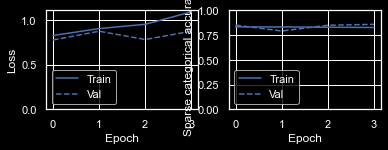

In [40]:
plot_metrics(history)

Evaluation using test dataset

Plot the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

  

In [ ]:
baseline_results = model.evaluate(X_test_vec, y_test_arr, batch_size = 128, verbose=0)

for name, value in zip(model.metrics_name)

Export an end-to-end model

Now, we may want to export a Model object that takes as input a string of arbitrary length, rather than a sequence of indices. It would make the model much more portable, since you wouldn't have to worry about the input preprocessing pipeline.

Our vectorizer is actually a Keras layer, so it's simple:

In [47]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

1/1 [==============================] - 0s 99ms/step
[5.488087e-04 9.994512e-01]


2023-09-17 23:09:07.386334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [51]:
# positive reviews
# the third one is an actual postitive review from AC6
# https://steamcommunity.com/id/bromancedance/recommended/1888160/

probabilities = end_to_end_model.predict(
    [["The game deserves a game of the year"], ["I enjoy playing it very much"], ["Fun, FUN, FUN!!!!!! Souls is one of my favorite series of all time, but never tried an AC game before this one. This game is the most fun I've had in a game in so long. Not just the high points, but the pacing just keeps you in the fun seat CONSTANTLY. After playing Starfield and Baldurs Gate 3 recently it felt ILLEGAL how often I was having a blast. I was constantly ready for the point of the game where the fun would slow down, but it only ramps up. TRULY a breath of fresh air in todays gaming climate."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 23ms/step


[[5.4880651e-04 9.9945122e-01]
 [1.1482235e-01 8.8517767e-01]
 [2.0211273e-05 9.9997973e-01]]


In [52]:
# negative reviews
# the second one: https://steamcommunity.com/id/x-pert_bandit/recommended/1091500/
# the third one: https://steamcommunity.com/profiles/76561197960511970/recommended/1716740/

probabilities = end_to_end_model.predict(
    [["Buying this game is wasting my money."], ["Now before all else is said, it is a good game, if it wasn't I wouldn't have put in so many hours elsewise. But save your cash until they've fixed a majority of the bugs and optimized it a bit more."], ["It is not a bad game. If you want Fallout in Space with dogfights, it absolutely delivers that. But the problems are that it feels very dated. The voice-acting and writing are embarrassingly bad, especially after coming off Baldurs Gate 3 where I found myself caring deeply about the characters and their stories. Starfield makes me want to skip dialog as fast as possible because it is so cringey. The main plot is about as cliched and uninspired as you can imagine. You are a no-name miner, but suddenly you are the crux of the whole plot and everyone just decides to make you the chosen one to do all the important stuff in a pre-existing group for no reason at all. It makes absolutely no sense when they had someone in their organization who had already experienced the mcguffin. The more I play it, the less I like it from the plot perspective. If people aren't playing for the plot, their experience will likely be better, but I still find the game feeling dated... Looks like I've played too much to refund it, which is disappointing, but the same issues still remain. The writing and voice-acting are reminiscent of a game from 1995 and really hold this game back."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 25ms/step
output: [0.99312115 0.00687893] ; class: 0
output: [0.02755235 0.9724477 ] ; class: 1
output: [0.9895983  0.01040172] ; class: 0


Save the model

In [53]:
end_to_end_model.save("keras_16-09-2023.keras")

------

load the model and test its inference.

In [54]:
loaded_model = tf.keras.saving.load_model("keras_16-09-2023.keras")

text = "I enjoy the game."

assert np.allclose(end_to_end_model.predict([[text]]), loaded_model.predict([[text]]))

1/1 [==============================] - 0s 104ms/step


2023-09-17 23:23:36.196972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
